In [1]:
# import importlib
# importlib.reload(config)
# import utils.config as config

# Visualization

In [2]:
# plot settings
import utils.Mycolor as Mycolor
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter

mycolor = Mycolor.Mycolor()
cm = mycolor.cm
cm_2 = mycolor.cm_2
cm_3 = mycolor.cm_3
cm_dp = mycolor.cm_dp

In [3]:
# prepare data

import pandas as pd
import utils.config as config
import utils.visualization_util as visualization_util

# original data and config
df_mlerr_label_config = pd.read_excel(config.path_default.joinpath('Manual_labeling/cluster_sampled_labeled_config.xlsx'),
                                keep_default_na=False)
exclude_config = ["label_if_code_error_align", "label_if_error_chain", "label_if_runinfo_help", "other"] 
# label_if_error_chain is the same as root cause.nb specific-previous cell error, others are not used here

df_mlerr_label_config.drop(exclude_config, axis=1, inplace=True)
# data
df_mlerr_labels = pd.read_excel(config.path_default.joinpath('Manual_labeling/cluster_sampled_labeled_processed.xlsx'))
df_mlerr_labels_g = df_mlerr_labels[df_mlerr_labels["nb_source"]==config.NB_SOURCE["github"]].reset_index(drop=True)
df_mlerr_labels_k = df_mlerr_labels[df_mlerr_labels["nb_source"]==config.NB_SOURCE["kaggle"]].reset_index(drop=True)
del df_mlerr_labels

print(df_mlerr_labels_g.eid.nunique())
print(df_mlerr_labels_k.eid.nunique())

# summed data and config
# config
df_mlerr_label_config_sum = pd.read_excel(config.path_default.joinpath('Manual_labeling/cluster_sampled_labeled_config_sum.xlsx'),
                                keep_default_na=False)
df_mlerr_label_config_sum.drop(exclude_config, axis=1, inplace=True)
# data
df_mlerr_labels_sum = pd.read_excel(config.path_default.joinpath('Manual_labeling/cluster_sampled_labeled_sum.xlsx'))
df_mlerr_labels_g_sum = df_mlerr_labels_sum[df_mlerr_labels_sum["nb_source"]==config.NB_SOURCE["github"]].reset_index(drop=True)
df_mlerr_labels_k_sum = df_mlerr_labels_sum[df_mlerr_labels_sum["nb_source"]==config.NB_SOURCE["kaggle"]].reset_index(drop=True)
del df_mlerr_labels_sum

# Summarize the statistics based on - df_mlerr_labels_sum
# github stats
cluster_res_g_sum = visualization_util.statistics_labels(df_mlerr_label_config_sum, df_mlerr_labels_g_sum)
for label_key in df_mlerr_label_config_sum:
    cluster_res_g_sum[label_key] = pd.DataFrame.from_dict(cluster_res_g_sum[label_key]).rename_axis('cluster_id').reset_index()
# for all clusters    
cluster_res_g_sum_weighted_sum = visualization_util.cal_weighted_sum(df_mlerr_label_config_sum, cluster_res_g_sum)

# kaggle stats
cluster_res_k_sum = visualization_util.statistics_labels(df_mlerr_label_config_sum, df_mlerr_labels_k_sum)
for label_key in df_mlerr_label_config_sum:
    cluster_res_k_sum[label_key] = pd.DataFrame.from_dict(cluster_res_k_sum[label_key]).rename_axis('cluster_id').reset_index()
cluster_res_k_sum_weighted_sum = visualization_util.cal_weighted_sum(df_mlerr_label_config_sum, cluster_res_k_sum)

path_default=WindowsPath('C:/Users/yirwa29/Downloads/data_jupyter_nbs_empirical')
390
356


### rq1: What are the prevalent exception types and root causes in ML notebooks?

In [4]:
# exception types
# top 10 + other (remainings)

cluster_res_exp_type_sum_weighted_sum = {x: cluster_res_k_sum_weighted_sum['label_refined_exp_type'].get(x, 0) + cluster_res_g_sum_weighted_sum['label_refined_exp_type'].get(x, 0)
                                         for x in set(cluster_res_k_sum_weighted_sum['label_refined_exp_type']).union(cluster_res_g_sum_weighted_sum['label_refined_exp_type'])}
df_cluster_res_exp_type_sum = pd.DataFrame(cluster_res_exp_type_sum_weighted_sum, index=["Combined"]).T.sort_values(by="Combined", ascending=False)
# include_num = 10
# df_cluster_res_exp_type_other = pd.DataFrame(df_cluster_res_exp_type_sum[include_num:].sum(axis=0)).T.rename(index={0: "other"})
# df_cluster_res_exp_type_sum = pd.concat([df_cluster_res_exp_type_sum[:include_num], df_cluster_res_exp_type_other])

df_cluster_res_exp_type_kg = pd.DataFrame([cluster_res_k_sum_weighted_sum['label_refined_exp_type'],
                   cluster_res_g_sum_weighted_sum['label_refined_exp_type']]).T.rename(columns={0: 'Kaggle', 1: 'GitHub'})

# df_cluster_res_exp_type_kg_other = pd.DataFrame(df_cluster_res_exp_type_kg[~df_cluster_res_exp_type_kg.index.isin(df_cluster_res_exp_type_sum.index[:include_num])].sum(axis=0)).T.rename(index={0: "other"})
# df_cluster_res_exp_type_kg = pd.concat([df_cluster_res_exp_type_kg.loc[df_cluster_res_exp_type_sum.index[:include_num].to_list()], df_cluster_res_exp_type_kg_other])
df_cluster_res_exp_type_kg = pd.concat([df_cluster_res_exp_type_sum, df_cluster_res_exp_type_kg], axis=1)
df_cluster_res_exp_type_kg.loc['total']= df_cluster_res_exp_type_kg.sum()

df_cluster_res_exp_type_kg.index.name = "Exception type"
df_cluster_res_exp_type_kg[["Combined","GitHub","Kaggle"]]

,Combined,GitHub,Kaggle
Exception type,,,
variable not found,133,72,61
invalid argument,73,40,33
io error,72,35,37
module not found,60,38,22
attribute error,52,29,23
key error,50,21,29
value error,43,19,24
tensor shape mismatch,41,18,23
type error,40,24,16


In [5]:
# transform to percentages
exp_plot = df_cluster_res_exp_type_kg.copy()
exp_plot.loc[:,'Kaggle']=(df_cluster_res_exp_type_kg['Kaggle']/df_cluster_res_exp_type_kg[:-1]['Kaggle'].sum()*100).round(2)
exp_plot.loc[:,'GitHub']=(df_cluster_res_exp_type_kg['GitHub']/df_cluster_res_exp_type_kg[:-1]['GitHub'].sum()*100).round(2)
exp_plot = exp_plot[:-1][["GitHub","Kaggle"]]

C:\Users\yirwa29\AppData\Local\Temp\ipykernel_10764\1978658013.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 17.13   9.27  10.39   6.18   6.46   8.15   6.74   6.46   4.49   5.06
   3.37   3.09   3.09   2.25   1.69   1.4    1.97   1.12   0.84   0.84
 100.  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  exp_plot.loc[:,'Kaggle']=(df_cluster_res_exp_type_kg['Kaggle']/df_cluster_res_exp_type_kg[:-1]['Kaggle'].sum()*100).round(2)
C:\Users\yirwa29\AppData\Local\Temp\ipykernel_10764\1978658013.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 18.46  10.26   8.97   9.74   7.44   5.38   4.87   4.62   6.15   2.82
   4.36   3.85   1.28   2.05   2.56   2.05   1.28   1.79   1.54   0.51
 100.  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  exp_plot.loc[:,'Git

In [6]:
# from matplotlib.ticker import PercentFormatter

# # plot
# ind = np.arange(len(exp_plot.index))

# width = 0.4
# fontsize = 11
# fig = plt.figure(figsize=(10,4))
# bars = plt.bar(ind - width / 2, exp_plot.GitHub, width, label = 'GitHub', alpha = 0.8, color = 'coral', edgecolor = 'black')
# for id_bar in range(len(bars)):
#     bar = bars[id_bar]
#     plt.text(bar.get_x(), bar.get_height()+.05, df_cluster_res_exp_type_kg.GitHub.iloc[id_bar], fontsize=fontsize-1)
# bars = plt.bar(ind + width / 2, exp_plot.Kaggle, width, label = 'Kaggle', alpha = 0.8, color = 'seagreen', edgecolor = 'black')
# for id_bar in range(len(bars)):
#     bar = bars[id_bar]
#     plt.text(bar.get_x(), bar.get_height()+.05, df_cluster_res_exp_type_kg.Kaggle.iloc[id_bar], fontsize=fontsize-1)

# # x ticks
# xticks_labels_new = [config.exp2abbr[x] for x in exp_plot.index]
# plt.xticks(ind, xticks_labels_new, rotation=45, fontsize=fontsize)
# plt.yticks(fontsize=fontsize)

# fig.axes[0].yaxis.set_major_formatter(PercentFormatter(decimals=0))
    
# # original legend   
# plt.legend(fontsize=fontsize) 

# # plt.savefig(config.path_plot_default.joinpath('exp.pdf'), bbox_inches='tight')
# plt.show()

In [7]:
# data prepare
# bug types (combined) with ml bug
nb_exp_mlbug_g = df_mlerr_labels_g_sum.groupby("label_refined_exp_type")["label_if_ML_bug"].value_counts().unstack("label_if_ML_bug").T
nb_exp_mlbug_k = df_mlerr_labels_k_sum.groupby("label_refined_exp_type")["label_if_ML_bug"].value_counts().unstack("label_if_ML_bug").T
nb_exp_mlbug_g.fillna(0, inplace=True)
nb_exp_mlbug_k.fillna(0, inplace=True)
nb_exp_mlbug = nb_exp_mlbug_g + nb_exp_mlbug_k
nb_exp_mlbug = nb_exp_mlbug[df_cluster_res_exp_type_kg.index[:-1]]

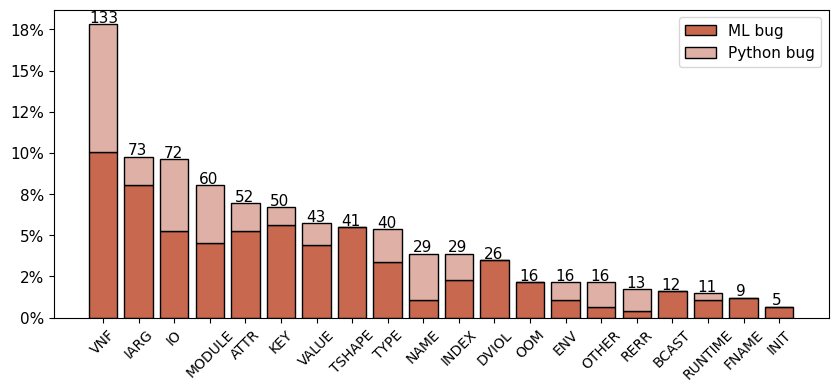

In [8]:
# plot
inds = np.arange(len(nb_exp_mlbug.columns))

width = 0.8
fontsize = 11
fig = plt.figure(figsize=(10,4))

weight_count = (nb_exp_mlbug*(df_cluster_res_exp_type_kg/df_cluster_res_exp_type_kg[:-1].sum())["Combined"][:-1]/nb_exp_mlbug.sum()*100).round(2)

bars = []
for ind in inds:
    bottom = 0
    for i in range(len(nb_exp_mlbug.index)):
        wg = weight_count[nb_exp_mlbug.columns[ind]]
        if i < len(wg.index):
            bar = plt.bar(ind, wg.iloc[i], width, alpha=1, color = cm_dp(240-i*60), edgecolor = 'black',  bottom=bottom) 
            bottom += wg.iloc[i]
    bars.append(bar)

for id_bar in range(len(bars)):
    bar = bars[id_bar][0]
    adjust_x = 0
    value_x = df_cluster_res_exp_type_kg["Combined"][:-1].iloc[id_bar]
    if value_x < 100:
        adjust_x = 0.1
    if value_x < 10:
        adjust_x = 0.2
    plt.text(bar.get_x() + adjust_x, 
             weight_count.sum().iloc[id_bar] + 0.1, 
             value_x, 
             fontsize=fontsize)

fig.axes[0].yaxis.set_major_formatter(PercentFormatter(decimals=0))
xticks_labels = [config.exp2abbr[x] for x in nb_exp_mlbug.columns]
plt.xticks(inds, xticks_labels, rotation=45, fontsize=fontsize-1)
plt.yticks(fontsize=fontsize)

# legend
lgd_colors = [cm_dp(240-i*60) for i in range(2)]
lgd_labels=["ML bug", "Python bug"]

lgnd = plt.legend(lgd_labels, loc="upper right", frameon=True, ncols=1, fontsize=fontsize, columnspacing=0.5)

i=0
for handle in lgnd.legend_handles:
    handle.set_color(lgd_colors[i])
    handle.set_edgecolor("black")
    i+=1 

plt.savefig(config.path_plot_default.joinpath("exp.pdf"), bbox_inches='tight')
plt.show()

In [9]:
# root cause
rc = pd.DataFrame([cluster_res_k_sum_weighted_sum['label_root_cause'],
                   cluster_res_g_sum_weighted_sum['label_root_cause']]).T.rename(columns={0: 'Kaggle', 1: 'GitHub'})

rc.index.name = "Root cause"
rc['Combined'] = rc['Kaggle']+rc['GitHub']
rc = rc.sort_values(by=['Combined'], ascending=False)
rc.loc['total']= rc.sum()
# print((rc['Combined'].loc['API']+rc['Combined'].loc['data']+rc['Combined'].loc['implementation'])/rc['Combined'].loc['total'])
rc[["Combined","GitHub","Kaggle"]]

,Combined,GitHub,Kaggle
Root cause,,,
API misuse,156,82,74
NB specific,145,75,70
implementation error,126,68,58
environment setting,125,70,55
data confusion,122,66,56
unknown,29,16,13
insufficient resource,17,6,11
ML model confusion,17,6,11
library cause,9,1,8


In [10]:
(rc/rc[:-1].sum()*100).round(2)[["Combined","GitHub","Kaggle"]]

,Combined,GitHub,Kaggle
Root cause,,,
API misuse,20.91,21.03,20.79
NB specific,19.44,19.23,19.66
implementation error,16.89,17.44,16.29
environment setting,16.76,17.95,15.45
data confusion,16.35,16.92,15.73
unknown,3.89,4.10,3.65
insufficient resource,2.28,1.54,3.09
ML model confusion,2.28,1.54,3.09
library cause,1.21,0.26,2.25


In [11]:
# zoom in to root cause == NB specific - xxx
nb_g = df_mlerr_labels_g[df_mlerr_labels_g["label_root_cause"].isin(config.label_root_cause["NB specific"])]
nb_g_counts = nb_g.groupby("label_root_cause")["label_root_cause"].value_counts().sort_values(ascending=False)
# merge out-of-order implementation into out-of-order execution
nb_g_counts["nb specific - execution order"] = nb_g_counts["nb specific - execution order"]+nb_g_counts["nb specific - need execute future cells"]
nb_g_counts = nb_g_counts[["nb specific - execution order","nb specific - previous cell error"]]
nb_g_counts = (nb_g_counts/nb_g_counts.sum()*100).round(2)
nb_k = df_mlerr_labels_k[df_mlerr_labels_k["label_root_cause"].isin(config.label_root_cause["NB specific"])]
nb_k_counts = nb_k.groupby("label_root_cause")["label_root_cause"].value_counts().sort_values(ascending=False)
nb_k_counts["nb specific - execution order"] = nb_k_counts["nb specific - execution order"]+nb_k_counts["nb specific - need execute future cells"]
nb_k_counts = nb_k_counts[["nb specific - execution order","nb specific - previous cell error"]]
nb_k_counts = (nb_k_counts/nb_k_counts.sum()*100).round(2)

nb_pp = pd.DataFrame([nb_g_counts,nb_k_counts],index=['GitHub','Kaggle'])
nb_pp.columns=["Out-of-order execution", "Previous cell error"] # "Out of order implementation"
nb_pp.index.name = 'NB specific'

nb_pp.T.astype(str) + '%'

NB specific,GitHub,Kaggle
Out-of-order execution,60.0%,74.29%
Previous cell error,40.0%,25.71%


In [12]:
# transform to percentages
rc_plot = rc[:-1].copy()
rc_plot.loc[:,'Kaggle']=(rc['Kaggle'][:-1]/rc['Kaggle'][:-1].sum()*100).round(2)
rc_plot.loc[:,'GitHub']=(rc['GitHub'][:-1]/rc['GitHub'][:-1].sum()*100).round(2)

rc_nb_g = rc_plot.loc["NB specific","GitHub"]
rc_nb_k = rc_plot.loc["NB specific","Kaggle"]
rc_plot.loc["NB specific","GitHub"]=0
rc_plot.loc["NB specific","Kaggle"]=0

C:\Users\yirwa29\AppData\Local\Temp\ipykernel_10764\198725025.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[20.79 19.66 16.29 15.45 15.73  3.65  3.09  3.09  2.25]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  rc_plot.loc[:,'Kaggle']=(rc['Kaggle'][:-1]/rc['Kaggle'][:-1].sum()*100).round(2)
C:\Users\yirwa29\AppData\Local\Temp\ipykernel_10764\198725025.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[21.03 19.23 17.44 17.95 16.92  4.1   1.54  1.54  0.26]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  rc_plot.loc[:,'GitHub']=(rc['GitHub'][:-1]/rc['GitHub'][:-1].sum()*100).round(2)


Index(['Out-of-order execution', 'Previous cell error'], dtype='object')


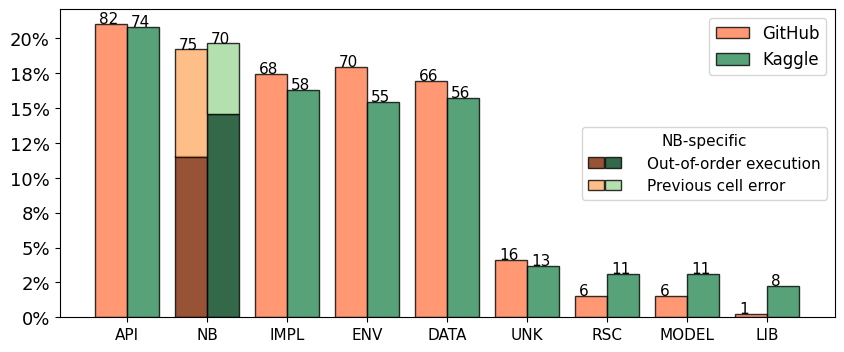

In [13]:
from matplotlib.ticker import PercentFormatter

# plot
ind = np.arange(len(rc_plot.index))

width = 0.4
fontsize = 16
fig = plt.figure(figsize=(10,4))
bars = plt.bar(ind - width / 2, rc_plot.GitHub, width, label = 'GitHub', alpha = 0.8, color = 'coral', edgecolor = 'black')
for id_bar in range(len(bars)):
    bar = bars[id_bar]
    if id_bar==1:
        plt.text(bar.get_x()+.05, rc_nb_g+.0, rc.GitHub.iloc[id_bar], fontsize=11)
        continue
    plt.text(bar.get_x()+.05, bar.get_height()+.05, rc.GitHub.iloc[id_bar], fontsize=11)

bars = plt.bar(ind + width / 2, rc_plot.Kaggle, width, label = 'Kaggle', alpha = 0.8, color = 'seagreen', edgecolor = 'black')
for id_bar in range(len(bars)):
    bar = bars[id_bar]
    if id_bar==1:
        plt.text(bar.get_x()+.05, rc_nb_k+.0, rc.Kaggle.iloc[id_bar], fontsize=11)
        continue
    plt.text(bar.get_x()+.05, bar.get_height()+.05, rc.Kaggle.iloc[id_bar], fontsize=11)


# np specific
npspe_list = nb_pp.T.index
weight_count_g = nb_pp.T["GitHub"]*rc_nb_g/100
weight_count_k = nb_pp.T["Kaggle"]*rc_nb_k/100
bottom_g, bottom_k = 0,0
for i in range(len(npspe_list)):
    plt.bar(1 - width / 2, weight_count_g.iloc[i], width, alpha=0.8, color = cm_2(i*5), edgecolor = 'black',  bottom=bottom_g) 
    bottom_g += weight_count_g.iloc[i]-0.03
    plt.bar(1 + width / 2, weight_count_k.iloc[i], width, alpha=0.8, color = cm(i*5), edgecolor = 'black',  bottom=bottom_k) 
    bottom_k += weight_count_k.iloc[i]-0.03

# x ticks
xticks_labels_new = [config.rc2abbr[x] for x in rc_plot.index]
plt.xticks(ind, xticks_labels_new, rotation=0, fontsize=fontsize-5)
plt.yticks(fontsize=fontsize-3)

fig.axes[0].yaxis.set_major_formatter(PercentFormatter(decimals=0))
# plt.xlabel("Exception types", fontsize=fontsize) 
# plt.ylabel("Percentage of errors", fontsize=fontsize) 

# np specific - add another legend
lgd_colors = [cm_2(i*5) for i in range(2)] + [cm(i*5) for i in range(2)]
print(npspe_list)
# legend 2 labels
lgd_labels=[""]*2+["Out-of-order execution", "Previous cell error"] #, "Out-of-order implementation"

lgnd = fig.axes[0].legend(labels=lgd_labels, loc="center right", ncols=2, fontsize=fontsize-5,columnspacing=-1.7, 
                          title="NB-specific", title_fontsize=fontsize-5)
fig.axes[0].add_artist(lgnd)
i=0
for handle in lgnd.legend_handles:
    handle.set_width(12)
    handle.set_color(lgd_colors[i])
    handle.set_edgecolor("black")
    i+=1
        
# original legend   
plt.legend(fontsize=fontsize-4) 

plt.savefig(config.path_plot_default.joinpath('rc.pdf'), bbox_inches='tight')
plt.show()

In [14]:
# calculate a combined relationship between rc and exp
df_grouped_g = df_mlerr_labels_g_sum.groupby("label_refined_exp_type")["label_root_cause"].value_counts().unstack("label_root_cause")
df_grouped_k = df_mlerr_labels_k_sum.groupby("label_refined_exp_type")["label_root_cause"].value_counts().unstack("label_root_cause")

df_grouped_g = df_grouped_g.fillna(0)
df_grouped_k = df_grouped_k.fillna(0)

df_grouped = df_grouped_g+df_grouped_k
df_grouped = (df_grouped.T/df_grouped.sum(axis=1)).fillna(0)
df_grouped_g = (df_grouped_g.T/df_grouped_g.sum(axis=1)).fillna(0)
df_grouped_k = (df_grouped_k.T/df_grouped_k.sum(axis=1)).fillna(0)

df_grouped = df_grouped.reindex(rc_plot.index)[nb_exp_mlbug.columns]
df_grouped_g = df_grouped_g.reindex(rc_plot.index)[nb_exp_mlbug.columns]
df_grouped_k = df_grouped_k.reindex(rc_plot.index)[nb_exp_mlbug.columns]

In [15]:
df_grouped

label_refined_exp_type,variable not found,invalid argument,io error,module not found,attribute error,key error,value error,tensor shape mismatch,type error,name error,index error,data value violation,OOM,environment error,other,request error,unsupported broadcast,runtime error,feature name mismatch,model initialization error
Root cause,,,,,,,,,,,,,,,,,,,,
API misuse,0.007519,0.657534,0.083333,0.000000,0.442308,0.22,0.348837,0.292683,0.425,0.000000,0.241379,0.307692,0.0,0.0625,0.0625,0.000000,0.166667,0.090909,0.222222,0.2
NB specific,0.639098,0.000000,0.013889,0.366667,0.057692,0.16,0.023256,0.048780,0.025,0.586207,0.034483,0.038462,0.0,0.0625,0.0000,0.000000,0.000000,0.000000,0.000000,0.4
implementation error,0.345865,0.068493,0.041667,0.083333,0.192308,0.10,0.139535,0.097561,0.225,0.379310,0.206897,0.038462,0.0,0.0625,0.1875,0.000000,0.333333,0.272727,0.333333,0.2
environment setting,0.000000,0.000000,0.833333,0.533333,0.076923,0.00,0.000000,0.000000,0.025,0.000000,0.000000,0.038462,0.0,0.7500,0.1250,0.846154,0.000000,0.181818,0.000000,0.0
data confusion,0.000000,0.136986,0.027778,0.000000,0.115385,0.50,0.418605,0.341463,0.200,0.000000,0.448276,0.500000,0.0,0.0000,0.1250,0.076923,0.500000,0.090909,0.333333,0.0
unknown,0.007519,0.041096,0.000000,0.016667,0.019231,0.02,0.023256,0.073171,0.075,0.034483,0.000000,0.076923,0.0,0.0000,0.3750,0.076923,0.000000,0.363636,0.000000,0.2
insufficient resource,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,1.0,0.0000,0.0625,0.000000,0.000000,0.000000,0.000000,0.0
ML model confusion,0.000000,0.068493,0.000000,0.000000,0.019231,0.00,0.046512,0.121951,0.025,0.000000,0.068966,0.000000,0.0,0.0000,0.0000,0.000000,0.000000,0.000000,0.111111,0.0
library cause,0.000000,0.027397,0.000000,0.000000,0.076923,0.00,0.000000,0.024390,0.000,0.000000,0.000000,0.000000,0.0,0.0625,0.0625,0.000000,0.000000,0.000000,0.000000,0.0


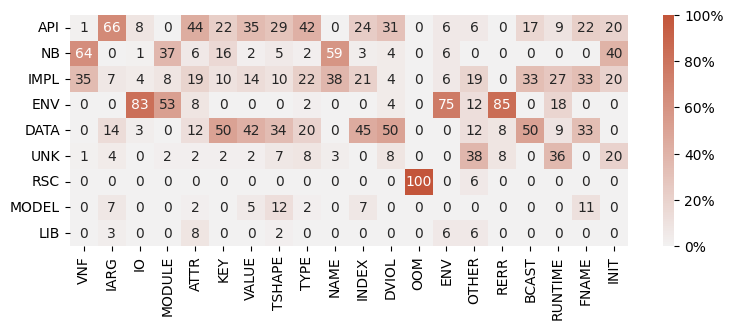

In [16]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(9,3))
# plot the heatmap for the combined dataset, rc and exp relationship in percentages
rc_new = [config.rc2abbr[x] for x in df_grouped.index]
exp_new = [config.exp2abbr[x] for x in df_grouped.columns]
s = sns.heatmap((df_grouped*100).round(0).astype(int), fmt = "d", cbar_kws={'format': '%d%%'},
                annot=True, yticklabels=rc_new, xticklabels=exp_new, 
                cmap=cm_dp,# "vlag", 
                center=0, ax=ax)
s.set(xlabel='', ylabel='')
s.figure.savefig(config.path_plot_default.joinpath('exp_rc_combined.pdf'), bbox_inches='tight')
plt.show()

# plot the heatmap for the differences in percentages
# s = sns.heatmap(((df_grouped_g-df_grouped_k)*100).round(0).astype(int).T, fmt = "d", cbar_kws={'format': '%d%%'},
#                 annot=True, xticklabels=rc_new, yticklabels=exp_new, 
#                 cmap=cm_dp,# "vlag", 
#                 center=0, vmin=-25, vmax=25)
# s.set(xlabel='', ylabel='')
# s.figure.savefig(config.path_plot_default.joinpath('exp_rc_diff.pdf'), bbox_inches='tight')
# plt.show()

### rq2: To what extent are failures in ML/data science notebooks related to ML libraries?

In [17]:
mlbug = pd.DataFrame([cluster_res_k_sum_weighted_sum['label_if_ML_bug'],
                   cluster_res_g_sum_weighted_sum['label_if_ML_bug']]).T.rename(columns={0: 'Kaggle', 1: 'GitHub'})
mlbug['combined'] = mlbug['Kaggle'] + mlbug['GitHub']
mlbug['combined']=(mlbug['combined']/mlbug['combined'].sum()*100).round(2)
mlbug['Kaggle']=(mlbug['Kaggle']/mlbug['Kaggle'].sum()*100).round(2)
mlbug['GitHub']=(mlbug['GitHub']/mlbug['GitHub'].sum()*100).round(2)

mlbug.index=["ML bug", "Python bug"]
mlbug.index.name = 'If ML bug'
mlbug #[["GitHub","Kaggle"]]

,Kaggle,GitHub,combined
If ML bug,,,
ML bug,73.03,62.82,67.69
Python bug,26.97,37.18,32.31


In [18]:
df_grouped_g = df_mlerr_labels_g_sum.groupby("label_if_ML_bug")["label_root_cause"].value_counts().unstack("label_root_cause")
# df_grouped_g.insert(6, "library", 0)
df_grouped_k = df_mlerr_labels_k_sum.groupby("label_if_ML_bug")["label_root_cause"].value_counts().unstack("label_root_cause")

df_grouped = df_grouped_g + df_grouped_k
df_grouped = (df_grouped.T/df_grouped.sum(axis=1)).fillna(0)
df_grouped_g = (df_grouped_g.T/df_grouped_g.sum(axis=1)).fillna(0)
df_grouped_k = (df_grouped_k.T/df_grouped_k.sum(axis=1)).fillna(0)

df_grouped_g = df_grouped_g.rename(columns={"python bug": "Python bug"})
df_grouped_k = df_grouped_k.rename(columns={"python bug": "Python bug"})
df_grouped = df_grouped.rename(columns={"python bug": "Python bug"})
df_grouped = df_grouped.reindex(rc_plot.index)

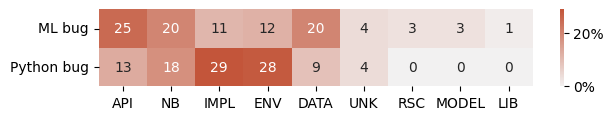

In [19]:
import seaborn as sns

# plot the heatmap for the combined dataset, rc and mlbug relationship in percentages
f,(ax1) = plt.subplots(1, 1, figsize=(7, 1))
rc_new = [config.rc2abbr[x] for x in df_grouped.index]
s = sns.heatmap((df_grouped*100).round(0).astype(int).T, fmt = "d", cbar_kws={'format': '%d%%'},
                annot=True, xticklabels=rc_new, 
                cmap=cm_dp,# "vlag", 
                center=0, #vmin=0, vmax=25,
                ax=ax1)
s.set(xlabel='', ylabel='')

f.savefig(config.path_plot_default.joinpath('mlbug_rc.pdf'), bbox_inches='tight')
plt.show()

### rq3: In which phases of ML development in notebooks are exceptions most likely to occur? 

In [20]:
df_mlpp = pd.DataFrame([cluster_res_k_sum_weighted_sum['label_ML_pipeline'],
                     cluster_res_g_sum_weighted_sum['label_ML_pipeline']]).T.rename(columns={0: 'Kaggle', 1: 'GitHub'})
df_mlpp.index.name = "ML pipeline"
df_mlpp = df_mlpp.reindex(config.order_mlpp)
df_mlpp.loc['total']= df_mlpp.sum()
df_mlpp['combined'] = df_mlpp['Kaggle']+df_mlpp['GitHub']
df_mlpp[['combined', 'GitHub', 'Kaggle']]

,combined,GitHub,Kaggle
ML pipeline,,,
environment setup,55,36,19
data preparation,246,147,99
data visualization,101,55,46
model construction,62,27,35
training,145,68,77
evaluation/prediction,137,57,80
total,746,390,356


In [21]:
(df_mlpp/df_mlpp[:-1].sum())[['combined', 'GitHub', 'Kaggle']]

,combined,GitHub,Kaggle
ML pipeline,,,
environment setup,0.073727,0.092308,0.053371
data preparation,0.329759,0.376923,0.278090
data visualization,0.135389,0.141026,0.129213
model construction,0.083110,0.069231,0.098315
training,0.194370,0.174359,0.216292
evaluation/prediction,0.183646,0.146154,0.224719
total,1.000000,1.000000,1.000000


In [22]:
# data prepare
# ml pipeline distribution
mlpp_raw = pd.DataFrame([cluster_res_k_sum_weighted_sum['label_ML_pipeline'],
                         cluster_res_g_sum_weighted_sum['label_ML_pipeline']]).T.rename(columns={0: 'Kaggle', 1: 'GitHub'})
mlpp = mlpp_raw.copy()
mlpp['Kaggle']=(mlpp_raw['Kaggle']/mlpp_raw['Kaggle'].sum()*100).round(2)
mlpp['GitHub']=(mlpp_raw['GitHub']/mlpp_raw['GitHub'].sum()*100).round(2)
mlpp = mlpp.reindex(config.order_mlpp)
mlpp_raw = mlpp_raw.reindex(config.order_mlpp)

# ml bug distribution for each pipeline
nb_mlpp_mlbug_g = df_mlerr_labels_g_sum.groupby("label_ML_pipeline")["label_if_ML_bug"].value_counts().unstack("label_if_ML_bug").T
nb_mlpp_mlbug_g.index = nb_mlpp_mlbug_g.index+"(GitHub)"
nb_mlpp_mlbug_k = df_mlerr_labels_k_sum.groupby("label_ML_pipeline")["label_if_ML_bug"].value_counts().unstack("label_if_ML_bug").T
nb_mlpp_mlbug_k.index = nb_mlpp_mlbug_k.index+"(Kaggle)"
# nb_mlpp_mlbug = pd.concat([nb_mlpp_mlbug_g, nb_mlpp_mlbug_k], axis=0)
nb_mlpp_mlbug_g_percent = (nb_mlpp_mlbug_g/nb_mlpp_mlbug_g.sum()).round(4)[config.order_mlpp]
nb_mlpp_mlbug_k_percent = (nb_mlpp_mlbug_k/nb_mlpp_mlbug_k.sum()).round(4)[config.order_mlpp]

In [23]:
nb_mlpp_mlbug_g_percent

label_ML_pipeline,environment setup,data preparation,data visualization,model construction,training,evaluation/prediction
label_if_ML_bug,,,,,,
ML bug(GitHub),0.4167,0.5102,0.6364,0.8889,0.8088,0.7193
python bug(GitHub),0.5833,0.4898,0.3636,0.1111,0.1912,0.2807


In [24]:
nb_mlpp_mlbug_k_percent

label_ML_pipeline,environment setup,data preparation,data visualization,model construction,training,evaluation/prediction
label_if_ML_bug,,,,,,
ML bug(Kaggle),0.1579,0.7172,0.7174,0.8,0.8701,0.725
python bug(Kaggle),0.8421,0.2828,0.2826,0.2,0.1299,0.275


In [25]:
0.7172/0.5102

1.4057232457859663

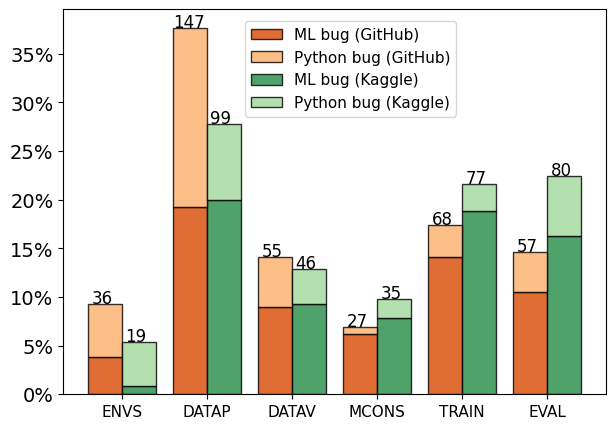

In [26]:
import numpy as np

def plot_mlpp_mlbug(mlpp, mlpp_raw, nb_mlpp_mlbug_g_percent, nb_mlpp_mlbug_k_percent, if_save = False, save_name="mlpp_mlbug.pdf"):
    # plot
    inds = np.arange(len(mlpp.index))

    width = 0.4
    fontsize = 16
    fig = plt.figure(figsize=(7,5))

    weight_count_g = (mlpp["GitHub"] * nb_mlpp_mlbug_g_percent)
    weight_count_k = (mlpp["Kaggle"] * nb_mlpp_mlbug_k_percent)

    bars_g = []
    bars_k = []
    for ind in inds:
        bottom_g, bottom_k = 0,0
        for i in range(max(len(nb_mlpp_mlbug_g_percent.index),len(nb_mlpp_mlbug_k_percent.index))):
            wg = weight_count_g[mlpp.index[ind]]
            if i < len(wg.index):
                bar_g = plt.bar(ind - width / 2, wg.iloc[i], width, alpha=0.8, color = cm_2(i*3+2), edgecolor = 'black',  bottom=bottom_g) 
                bottom_g += wg.iloc[i]
            wk = weight_count_k[mlpp.index[ind]]
            if i < len(wk.index):
                bar_k = plt.bar(ind + width / 2, wk.iloc[i], width, alpha=0.8, color = cm(i*3+2), edgecolor = 'black',  bottom=bottom_k) 
                bottom_k += wk.iloc[i]
        bars_g.append(bar_g)
        bars_k.append(bar_k)

    for id_bar in range(len(bars_g)):
        bar_g = bars_g[id_bar][0]
        bar_k = bars_k[id_bar][0]
        adjust_x = .04
        if mlpp_raw.GitHub.iloc[id_bar]>99:
            adjust_x = .0
        plt.text(bar_g.get_x()+adjust_x, mlpp.GitHub.iloc[id_bar]+.08, mlpp_raw.GitHub.iloc[id_bar], fontsize=fontsize-4)
        adjust_x = .04
        if mlpp_raw.Kaggle.iloc[id_bar]>99:
            adjust_x = .0
        plt.text(bar_k.get_x()+adjust_x, mlpp.Kaggle.iloc[id_bar]+.08, mlpp_raw.Kaggle.iloc[id_bar], fontsize=fontsize-4)

    fig.axes[0].yaxis.set_major_formatter(PercentFormatter(decimals=0))
    xticks_labels = [config.mlpp2abbr[x] for x in mlpp.index]
    plt.xticks(inds, xticks_labels, rotation=0, fontsize=fontsize-5)
    plt.yticks(fontsize=fontsize-2)

    # legend
    lgd_colors = [cm_2(i*3+2) for i in range(2)] + [cm(i*3+2) for i in range(2)]
    lgd_labels=["ML bug (GitHub)", "Python bug (GitHub)", "ML bug (Kaggle)", "Python bug (Kaggle)"]

    # lgnd = plt.legend(lgd_labels, loc="upper center", ncols=2, fontsize=fontsize-5, columnspacing=0.5)
    lgnd = plt.legend(lgd_labels, bbox_to_anchor=(0.53, 0.845), loc="center", frameon=True, ncols=1, fontsize=fontsize-5, columnspacing=0.5)

    i=0
    for handle in lgnd.legend_handles:
    #     handle.set_width(11)
        handle.set_color(lgd_colors[i])
        handle.set_edgecolor("black")
        i+=1 

    if if_save:
        plt.savefig(config.path_plot_default.joinpath("{}".format(save_name)), bbox_inches='tight')
    plt.show()
    return weight_count_g, weight_count_k
    
weight_count_g, weight_count_k = plot_mlpp_mlbug(mlpp, mlpp_raw, nb_mlpp_mlbug_g_percent, nb_mlpp_mlbug_k_percent, 
                                                 if_save = True, save_name="mlpp_mlbug.pdf")

In [27]:
# rc distribution for each pipeline

nb_mlpp_rc_g = df_mlerr_labels_g_sum.groupby("label_ML_pipeline")["label_root_cause"].value_counts().unstack("label_root_cause").T
nb_mlpp_rc_k = df_mlerr_labels_k_sum.groupby("label_ML_pipeline")["label_root_cause"].value_counts().unstack("label_root_cause").T

nb_mlpp_rc_g = nb_mlpp_rc_g.fillna(0)
nb_mlpp_rc_k = nb_mlpp_rc_k.fillna(0)
nb_mlpp_rc = nb_mlpp_rc_g + nb_mlpp_rc_k

nb_mlpp_rc_percent = (nb_mlpp_rc/nb_mlpp_rc.sum())[config.order_mlpp].fillna(0)
nb_mlpp_rc_percent = nb_mlpp_rc_percent.reindex(rc_plot.index)

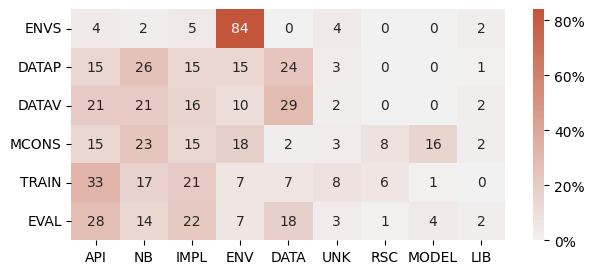

In [28]:
f,(ax1) = plt.subplots(1, 1, figsize=(7, 3))
# ax1.get_shared_y_axes().join(ax2)
rc_new = [config.rc2abbr[x] for x in nb_mlpp_rc_percent.index]
mlpp_new = [config.mlpp2abbr[x] for x in nb_mlpp_rc_percent.columns]
s = sns.heatmap((nb_mlpp_rc_percent*100).round(0).astype(int).T, fmt = "d", cbar_kws={'format': '%d%%'},
                annot=True, xticklabels=rc_new, yticklabels=mlpp_new,
                cmap=cm_dp,# "vlag", 
                center=0, #vmin=0, vmax=50,
                ax=ax1)
s.set(xlabel='', ylabel='')
plt.savefig(config.path_plot_default.joinpath('mlpp_rc.pdf'), bbox_inches='tight')
plt.show()